Codigo realizado por 

David Ortiz, Ph.D.

Escuela de Ingeniería Biomédica

Universidad de Valparaíso

# Análisis Temporal en Señales con Ventanas Superpuestas

En este análisis, se aplican métricas avanzadas al dominio temporal para analizar características dinámicas y estadísticas de una señal subdividida en ventanas. Las métricas incluyen **velocidad media**, **aceleración media**, **entropía de Shannon**, **RMS**, **cruces por cero** y la **varianza de cruces por cero**. Las ventanas se superponen según un porcentaje definido.

## Descripción de las Métricas

### 1. Velocidad Media
- **Descripción**: Representa la tasa promedio de cambio de la señal dentro de cada ventana.
- **Fórmula**: $\text{Velocidad Media} = \frac{1}{N-1} \sum_{n=1}^{N-1} \left|x[n+1] - x[n]\right|$

### 2. Aceleración Media
- **Descripción**: Representa el cambio promedio de la velocidad (segunda derivada de la señal) dentro de cada ventana.
- **Fórmula**: $\text{Aceleración Media} = \frac{1}{N-2} \sum_{n=1}^{N-2} \left|x[n+2] - 2x[n+1] + x[n]\right|$

### 3. Entropía de Shannon
- **Descripción**: Mide el nivel de desorden o aleatoriedad de la señal dentro de la ventana.
- **Fórmula**: $\text{Entropía} = - \sum_{i=1}^M p_i \log(p_i)$

  Donde $p_i$ es la probabilidad de ocurrencia de los valores de la señal.

### 4. RMS (Root Mean Square)
- **Descripción**: Nivel promedio de energía de la señal.
- **Fórmula**: $\text{RMS} = \sqrt{\frac{1}{N} \sum_{n=1}^N x[n]^2}$

### 5. Cruces por Cero
- **Descripción**: Número de veces que la señal cruza el eje horizontal dentro de la ventana, útil para estimar cambios en la frecuencia de la señal.
- **Fórmula**: $ \text{Cruces por cero} = \sum_{n=1}^{N-1} \mathbb{1}(x[n] \cdot x[n+1] < 0)$

### 6. Varianza de los Cruces por Cero
- **Descripción**: Mide la dispersión de los intervalos entre cruces consecutivos, útil para analizar cambios en la periodicidad de la señal.
- **Fórmula**: $\text{Varianza Cruces} = \text{Var}(t_{\text{cruces}})$

C:\Users\maxim\AppData\Local\Temp\ipykernel_25472\2387346195.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


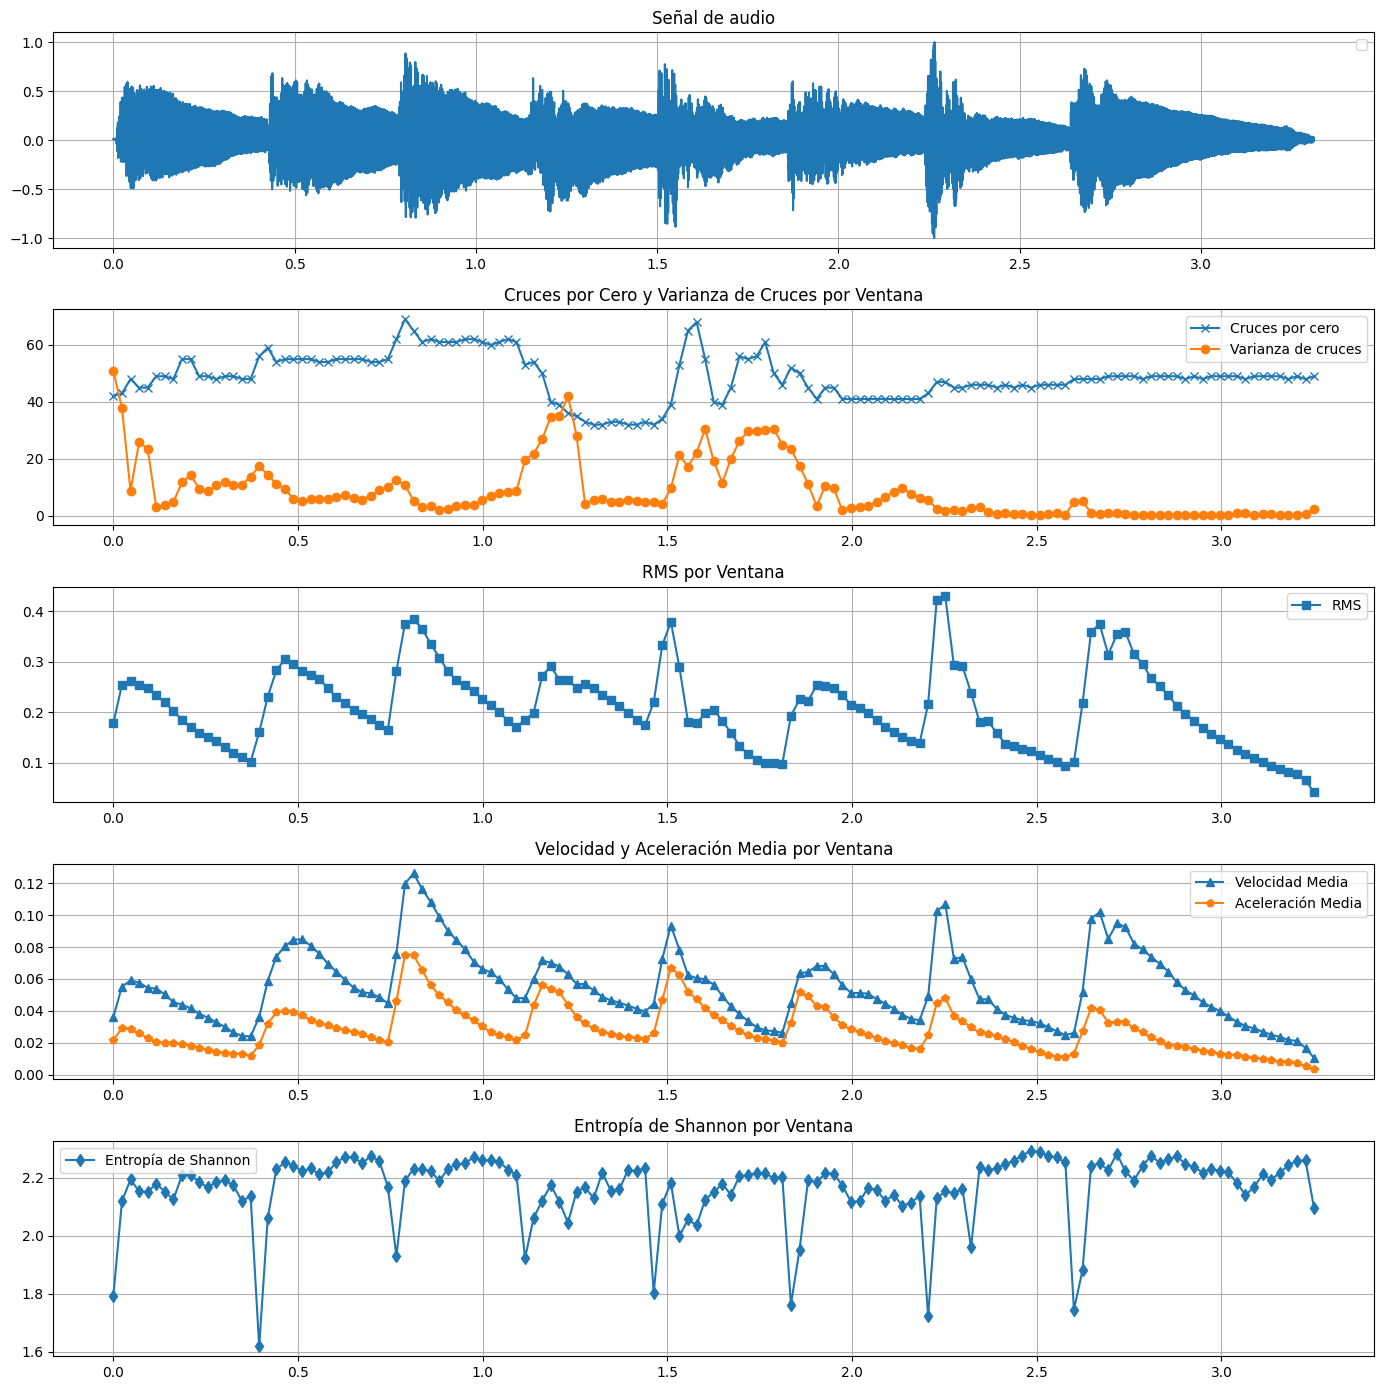

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile
from scipy.signal import get_window
from scipy.stats import entropy


# Función para importar y reproducir el archivo de audio
def load_and_play_wav(filename):
    # Leer el archivo .wav
    sample_rate, signal = wavfile.read(filename)
    signal = signal.astype(np.float32)
    signal_norm = 2 * (signal - np.min(signal)) / (np.max(signal) - np.min(signal)) - 1

    # Reproducir el audio
    display(Audio(data=signal, rate=sample_rate))
    return sample_rate, signal_norm

sample_rate, signal = load_and_play_wav('./Archivos/piano.wav')
t = np.linspace(0, len(signal)/sample_rate, len(signal))

# Parámetros para el análisis en ventanas
window_size = 512  # Número de puntos por ventana
overlap_percentage = 0.5  # Porcentaje de superposición (0 a 1)
window_type='boxcar'
step_size = int(window_size * (1 - overlap_percentage))  # Tamaño del paso entre ventanas
window_function = get_window(window_type, window_size)

# Inicialización de métricas
velocity_values = []
acceleration_values = []
shannon_entropy = []
zero_crossing_variances = []
rms_values = []
zero_crossings = []
window_start_times = []

# Cálculo de métricas por ventana con superposición
for start in range(0, len(signal) - window_size + 1, step_size):
    window = signal[start:start + window_size] * window_function  # Aplica la ventana Hamming
    window_start_times.append(t[start])

    # Velocidad media (primera derivada promedio)
    velocity = np.mean(np.abs(np.diff(window)))
    velocity_values.append(velocity)
    # Aceleración media (segunda derivada promedio)
    acceleration = np.mean(np.abs(np.diff(np.diff(window))))
    acceleration_values.append(acceleration)
    # Entropía de Shannon
    hist, _ = np.histogram(window, bins=10, density=True)
    shannon_entropy.append(entropy(hist + 1e-12))  # Agrega constante para evitar log(0)
    # RMS
    rms_values.append(np.sqrt(np.mean(window**2)))
    # Cruces por cero
    zero_crossing_locs = np.where(np.diff(np.sign(window)) != 0)[0]
    zero_crossings.append(len(zero_crossing_locs))
    # Varianza de los intervalos entre cruces por cero
    if len(zero_crossing_locs) > 1:
        intervals = np.diff(zero_crossing_locs)
        zero_crossing_variances.append(np.var(intervals))
    else:
        zero_crossing_variances.append(0)

# Visualización de resultados
plt.figure(figsize=(14, 14))

# Señal original con ruido
plt.subplot(5, 1, 1)
plt.plot(t, signal)
plt.title('Señal de audio')
plt.grid()
plt.legend()

# Cruces por Cero y Varianza
plt.subplot(5, 1, 2)
plt.plot(window_start_times, zero_crossings, 'x-', label='Cruces por cero')
plt.plot(window_start_times, zero_crossing_variances, 'o-', label='Varianza de cruces')
plt.title('Cruces por Cero y Varianza de Cruces por Ventana')
plt.legend()
plt.grid()

# RMS
plt.subplot(5, 1, 3)
plt.plot(window_start_times, rms_values, 's-', label='RMS')
plt.title('RMS por Ventana')
plt.legend()
plt.grid()

# Velocidad y Aceleración Media
plt.subplot(5, 1, 4)
plt.plot(window_start_times, velocity_values, '^-', label='Velocidad Media')
plt.plot(window_start_times, acceleration_values, 'p-', label='Aceleración Media')
plt.title('Velocidad y Aceleración Media por Ventana')
plt.legend()
plt.grid()

# Entropía de Shannon
plt.subplot(5, 1, 5)
plt.plot(window_start_times, shannon_entropy, 'd-', label='Entropía de Shannon')
plt.title('Entropía de Shannon por Ventana')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


# Transformada de Hilbert y Cálculo de la Envolvente

La envolvente de una señal es una curva que sigue los máximos de la amplitud oscilatoria. Este cálculo se realiza utilizando la **transformada de Hilbert** para obtener la señal analítica y procesarla.

---

## Definición de la Transformada de Hilbert

La **transformada de Hilbert** de una función $g(t)$ está definida como:

\begin{equation}
\mathcal{H}[g(t)] = \frac{1}{\pi} \int_{-\infty}^\infty \frac{g(\tau)}{t - \tau} \, d\tau.
\end{equation}

En el dominio de Fourier, esta transformada se simplifica como:

\begin{equation}
\mathcal{F}\{\mathcal{H}[g(t)]\} = G(\omega)[-j \, \text{sgn}(\omega)],
\end{equation}

donde:
- $G(\omega)$ es la transformada de Fourier de $g(t)$.
- $\text{sgn}(\omega)$ es la función signo:
  $$
  \text{sgn}(\omega) =
  \begin{cases}
  -1, & \omega < 0 \\
   0, & \omega = 0 \\
   1, & \omega > 0.
  \end{cases}
  $$

El resultado introduce un desfase de $-\pi/2$ para las frecuencias positivas y $+\pi/2$ para las negativas.

---

## Señal Analítica

Con la transformada de Hilbert, se construye la **señal analítica**:

\begin{equation}
\psi(t) = g(t) + j \mathcal{H}[g(t)],
\end{equation}

donde:
- $g(t)$: Señal original.
- $\mathcal{H}[g(t)]$: Transformada de Hilbert de la señal.

La magnitud de esta señal analítica representa la **envolvente**:

\begin{equation}
|\psi(t)| = \sqrt{g(t)^2 + \mathcal{H}[g(t)]^2}.
\end{equation}

---

## Decimación y Suavizado

1. **Decimación**:
   Para reducir la resolución temporal de la envolvente, se realiza una **decimación** sobre $|\psi(t)|$. Esto disminuye la cantidad de datos sin perder características significativas, aplicando un filtro FIR para prevenir aliasing.

2. **Filtrado Pasabajas**:
   Se utiliza un filtro Butterworth para suavizar la envolvente. Este filtro tiene la forma:

\begin{equation}
H(s) = \frac{1}{\sqrt{1 + \left(\frac{\omega}{\omega_c}\right)^{2n}}},
\end{equation}

donde:
- $\omega_c$: Frecuencia de corte.
- $n$: Orden del filtro.

El resultado final es una envolvente limpia y suavizada que captura las variaciones principales de la señal.

---

## Proceso Completo

1. **Transformada de Hilbert**: Se calcula $\mathcal{H}[g(t)]$ para obtener la señal analítica $\psi(t)$.
2. **Magnitud**: Se calcula $|\psi(t)|$ como la envolvente inicial.
3. **Decimación**: Se reduce la cantidad de muestras en $|\psi(t)|$ aplicando un filtro FIR.
4. **Filtrado Suavizado**: Se filtra la envolvente decimada con un filtro Butterworth.

Este flujo garantiza una representación precisa y suave de la envolvente de la señal.


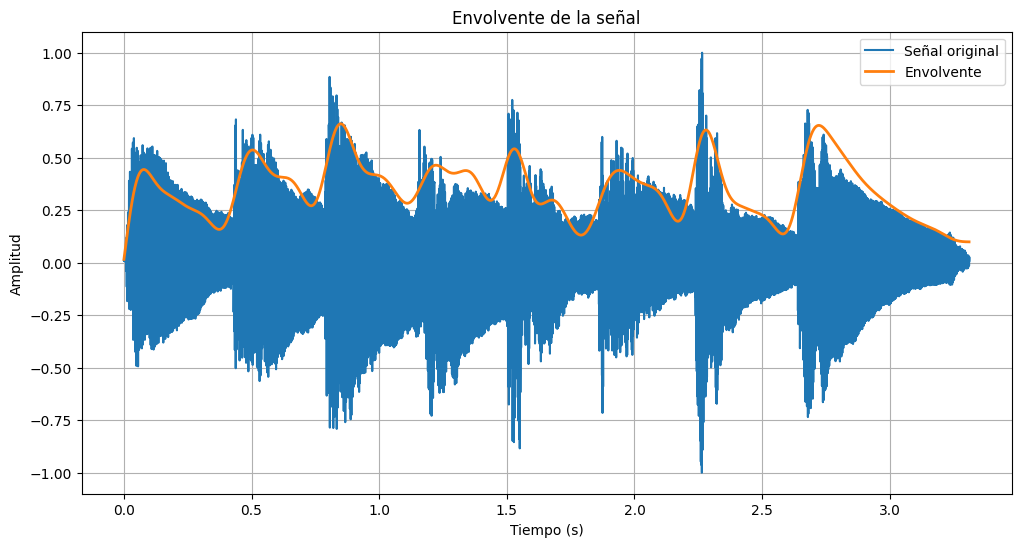

In [ ]:
from scipy.signal import butter, filtfilt, hilbert, decimate

def envelope(data, fs, dec):
    """
    Calcula la envolvente de una señal.

    Parameters:
    - data: ndarray
        Señal de entrada.
    - fs: float
        Frecuencia de muestreo.
    - dec: int
        Factor de decimación.

    Returns:
    - env: ndarray
        Señal de envolvente.
    """

    # Asegurar que los datos sean un vector columna
    if data.ndim > 1 and data.shape[0] < data.shape[1]:
        data = data.T  # Transponer si es necesario

    # Transformada de Fourier de los datos
    ff_data = np.fft.fft(data)

    # Transformada de Hilbert (frecuencia positiva)
    f_pos = np.fft.ifft(ff_data * (-1j))

    # Señal analítica: parte real es la señal original, parte imaginaria es la transformada de Hilbert
    an_sig = data + 1j * f_pos

    # Magnitud de la señal analítica (envolvente)
    analytic_env = np.abs(an_sig)

    # Decimación de la envolvente para reducir la frecuencia de muestreo
    env_decimated = decimate(analytic_env, dec, ftype='fir')

    # Parámetros para el filtro Butterworth
    nyquist = fs / 2  # Frecuencia de Nyquist
    cutoff = nyquist / (2 * dec)  # Frecuencia de corte
    order = 6  # Orden del filtro
    b, a = butter(order, cutoff / nyquist, btype='low')  # Diseña filtro Butterworth

    # Filtrado para suavizar la señal
    env_smoothed = filtfilt(b, a, env_decimated)

    return env_smoothed

dec = 20
# Calcular la envolvente
env = envelope(signal, sample_rate, dec=dec)

# Visualización
plt.figure(figsize=(12, 6))
plt.plot(t, signal, label="Señal original")
plt.plot(t[::dec], env, label="Envolvente", linewidth=2)
plt.title("Envolvente de la señal")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.legend()
plt.grid()
plt.show()


# Análisis Temporal: Crestas y Valles, Autocorrelación, Frecuencia y Derivadas

---

### **3. Detección de Crestas y Valles**
- **Descripción**: Identifica máximos (crestas) y mínimos (valles) locales en una señal. Es útil para analizar patrones periódicos y oscilaciones.
- **Definición Matemática**:
  \begin{equation}
  \text{Cresta: } x[n] > x[n-1] \, \text{y} \, x[n] > x[n+1],
  \end{equation}
  \begin{equation}
  \text{Valle: } x[n] < x[n-1] \, \text{y} \, x[n] < x[n+1].
  \end{equation}

---

### **4. Autocorrelación**
- **Descripción**: Mide la similitud de una señal consigo misma a diferentes retardos, útil para identificar periodicidad.
- **Definición Matemática**:

  \begin{equation}
  R[k] = \sum_{n=0}^{N-1-k} x[n] \cdot x[n+k],
  \end{equation}
  donde \( k \) es el retardo.

---

### **6. Frecuencia y Fase Instantánea**
- **Descripción**: La fase instantánea describe el desfase de la señal en cada instante, mientras que la frecuencia instantánea mide el cambio temporal de la fase.
- **Definiciones Matemáticas**:
  \begin{equation}
  \phi(t) = \arctan\left(\frac{\mathcal{H}[x(t)]}{x(t)}\right),
  \end{equation}
  \begin{equation}
  f_{\text{inst}}(t) = \frac{1}{2\pi} \frac{d\phi(t)}{dt}.
  \end{equation}

---

### **7. Derivadas**
- **Descripción**: Las derivadas de la señal describen su cambio temporal. La primera derivada evalúa la velocidad, y la segunda mide la aceleración.
- **Definiciones Matemáticas**:
  \begin{equation}
  v(t) = \frac{dx(t)}{dt}, \quad a(t) = \frac{d^2x(t)}{dt^2}.
  \end{equation}

---


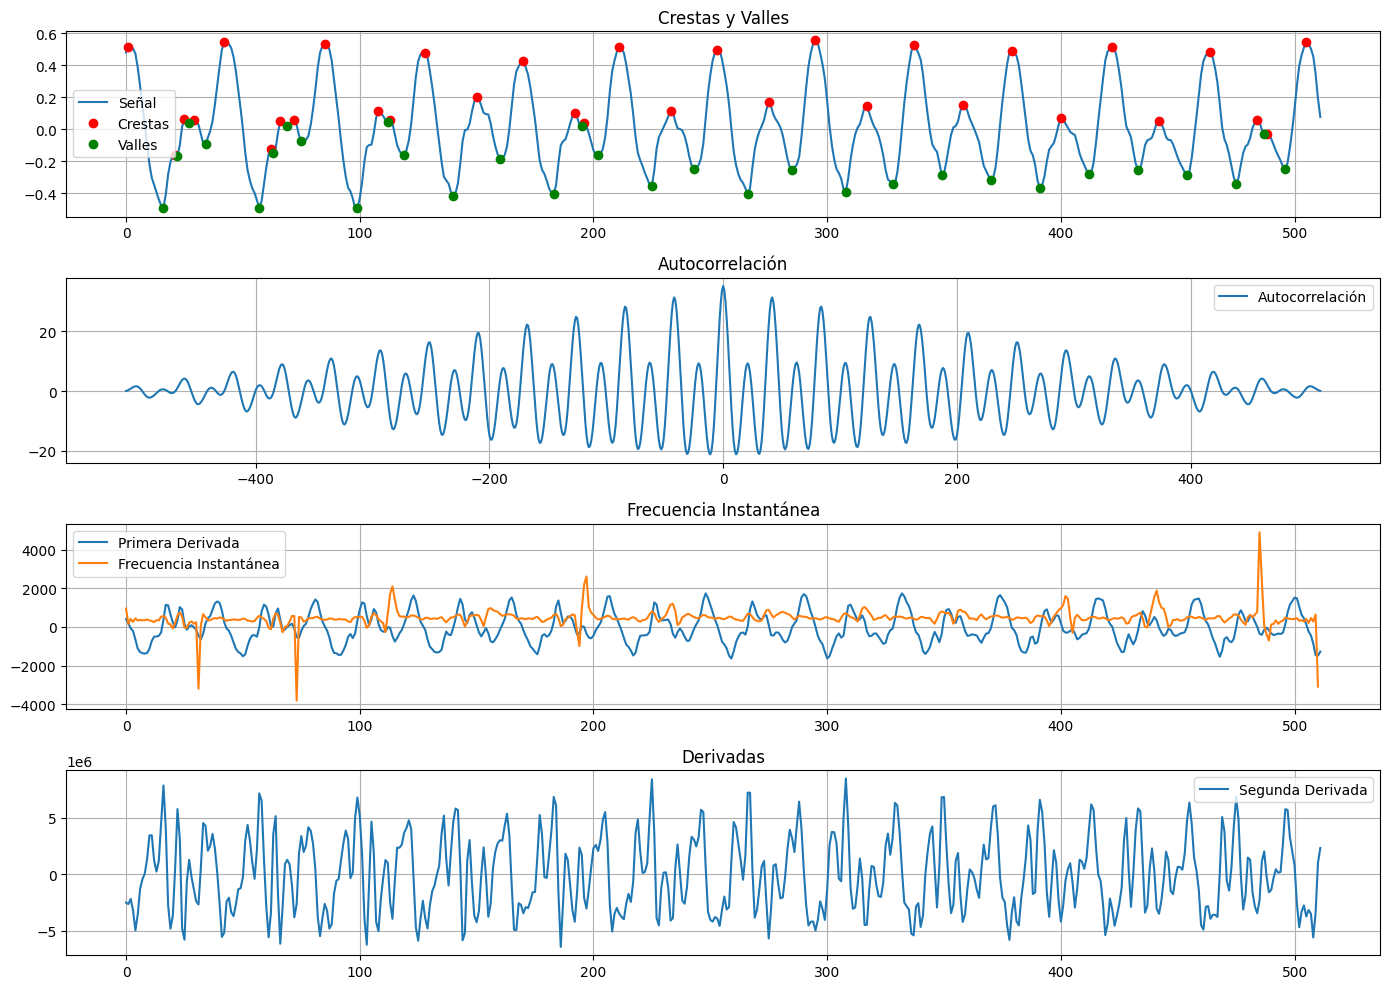

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, hilbert

# Inicialización de métricas
window_start_times = []
peaks_all = []
valleys_all = []
autocorr_all = []
freq_instant_all = []
phase_instant_all = []
first_derivatives = []
second_derivatives = []

# Cálculo en ventanas
for start in range(0, len(signal) - window_size + 1, step_size):
    window = signal[start:start + window_size]
    window_start_times.append(start)

    # 3. Detección de Crestas y Valles
    peaks, _ = find_peaks(window)
    valleys, _ = find_peaks(-window)
    peaks_all.append(peaks)
    valleys_all.append(valleys)

    # 4. Autocorrelación
    autocorr = np.correlate(window, window, mode='full')
    autocorr_all.append(autocorr)

    # 6. Frecuencia y Fase Instantánea
    analytic_signal = hilbert(window)
    phase = np.unwrap(np.angle(analytic_signal))
    freq_instant = np.diff(phase) / (2.0 * np.pi * (t[1] - t[0]))
    phase_instant_all.append(phase)
    freq_instant_all.append(freq_instant)

    # 7. Derivadas
    first_derivative = np.gradient(window, t[start:start + window_size])
    second_derivative = np.gradient(first_derivative, t[start:start + window_size])
    first_derivatives.append(first_derivative)
    second_derivatives.append(second_derivative)



start_idx = 2
window_signal = signal[window_start_times[start_idx]:window_start_times[start_idx]+window_size]
peaks = peaks_all[start_idx]
valleys = valleys_all[start_idx]
autocorr = autocorr_all[start_idx]
phase = phase_instant_all[start_idx]
freq_instant = freq_instant_all[start_idx]
first_derivative = first_derivatives[start_idx]
second_derivative = second_derivatives[start_idx]

plt.figure(figsize=(14, 10))

# Señal con crestas y valles
plt.subplot(4, 1, 1)
plt.plot(window_signal, label='Señal')
plt.plot(peaks, window_signal[peaks], 'ro', label='Crestas')
plt.plot(valleys, window_signal[valleys], 'go', label='Valles')
plt.title("Crestas y Valles")
plt.legend()
plt.grid()

# Autocorrelación
plt.subplot(4, 1, 2)
plt.plot(np.arange(-window_size + 1, window_size), autocorr, label="Autocorrelación")
plt.legend()
plt.title("Autocorrelación")
plt.grid()

# Frecuencia Instantánea
plt.subplot(4, 1, 3)
plt.plot(first_derivative, label="Primera Derivada")
plt.plot(freq_instant, label="Frecuencia Instantánea")
plt.legend()
plt.title("Frecuencia Instantánea")
plt.grid()

# Derivadas
plt.subplot(4, 1, 4)
plt.plot(second_derivative, label="Segunda Derivada")
plt.title("Derivadas")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Cambia start_idx para graficar una ventana específica


# Medidas para Cuantificar la Atenuación de un Filtro

---

## **1. Relación Señal a Ruido (SNR)**
- **Descripción**: La SNR mide la relación entre la potencia de la señal y la potencia del ruido, antes y después del filtrado.
- **Definición Matemática**:
  \begin{equation}
  \text{SNR (dB)} = 10 \log_{10} \left( \frac{\sum x_{\text{señal}}^2}{\sum x_{\text{ruido}}^2} \right),
  \end{equation}
  donde:
  - $x_{\text{señal}}$: Señal filtrada.
  - $x_{\text{ruido}} = x_{\text{original}} - x_{\text{filtrada}}$: Ruido residual después del filtrado.

---

## **3. Cociente RMS (Root Mean Square)**
- **Descripción**: Compara la energía entre la señal original y la señal filtrada para evaluar la atenuación.
- **Definición Matemática**:
  \begin{equation}
  \text{Cociente RMS (dB)} = 20 \log_{10} \left( \frac{\text{RMS}_{\text{filtrada}}}{\text{RMS}_{\text{original}}} \right),
  \end{equation}
  donde:
  $$
  \text{RMS} = \sqrt{\frac{1}{N} \sum_{n=1}^N x[n]^2}.
  $$

---

## **4. Atenuación en Frecuencia Específica**
- **Descripción**: Mide la reducción de la magnitud en una frecuencia particular usando la FFT.
- **Definición Matemática**:
  \begin{equation}
  \text{Atenuación (dB, frecuencia } f_0 \text{)} = 20 \log_{10} \left( \frac{|\text{FFT}_{\text{filtrada}}(f_0)|}{|\text{FFT}_{\text{original}}(f_0)|} \right).
  \end{equation}

---

## **Interpretación de los Resultados**

### **Relación Señal a Ruido (SNR):**
- **Valores altos (SNR positiva):** Indican que el filtro mejora la señal respecto al ruido. Un aumento significativo (> 10 dB) es ideal para reducir el ruido.
- **Valores bajos o negativos:** Indican degradación de la calidad, posiblemente porque el filtro eliminó partes importantes de la señal.

### **Cociente RMS:**
- **Valores positivos ("malo"):** La señal filtrada conserva más energía en comparación con la original, lo que podría indicar que el filtro amplifica ciertas bandas.
- **Valores negativos ("bueno"):**  indican que el filtro está reduciendo la energía total de la señal, lo cual es esperado en filtros de atenuación.

### **Atenuación en Frecuencia:**
- **Valores bajos (por ejemplo, <-20dB):** Representan una atenuación efectiva en la frecuencia de interés, útil para eliminar ruido o señales indeseadas.
- **Valores altos:** Sugieren que el filtro tiene poco impacto en la frecuencia específica, lo cual puede ser deseado si esa banda no debe ser modificada.

---

SNR antes del filtrado: 16.77 dB
SNR después del filtrado: 16.42 dB
Cociente RMS: -0.10 dB
Atenuación en 231 Hz: -50.96 dB


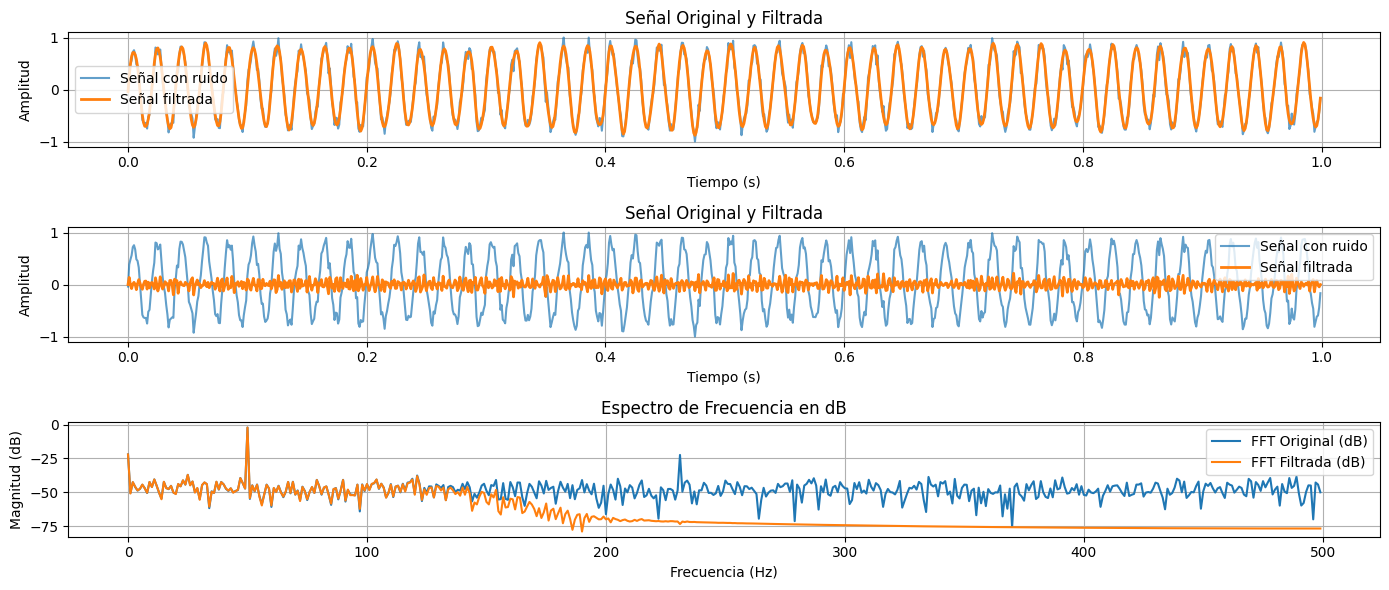

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np


# Generación de señal de prueba
fs = 1000  # Frecuencia de muestreo
fn = 231 # frecuencia del ruido
t = np.linspace(0, 1, fs, endpoint=False)
signal_original = np.sin(2 * np.pi * 50 * t) + 0.1 * np.sin(2 * np.pi * fn * t)  # Señal original
noise = np.random.normal(0, 0.1, len(t))  # Ruido
signal_wn = signal_original + noise
signal_with_noise = 2 * (signal_wn - np.min(signal_wn)) / (np.max(signal_wn) - np.min(signal_wn)) - 1


# Filtro pasa-bajas
fc = 100  # Frecuencia de corte
order = 6
b, a = butter(order, 150, btype='low', fs = fs)  # Filtro Butterworth
signal_filtered = filtfilt(b, a, signal_with_noise)

# 1. Relación Señal a Ruido (SNR)
noise_residual = signal_with_noise - signal_filtered
snr_before = 10 * np.log10(np.sum(signal_original**2) / np.sum(noise**2))
snr_after = 10 * np.log10(np.sum(signal_filtered**2) / np.sum(noise_residual**2))

# 3. Cociente RMS
rms_original = np.sqrt(np.mean(signal_with_noise**2))
rms_filtered = np.sqrt(np.mean(signal_filtered**2))
rms_ratio = 20 * np.log10(rms_filtered / rms_original)

# 4. Atenuación en Frecuencia Específica
fft_original = np.fft.fft(signal_with_noise)
fft_filtered = np.fft.fft(signal_filtered)
frequencies = np.fft.fftfreq(len(t), 1 / fs)
target_frequency = fn  # Frecuencia de interés
target_idx = np.argmin(np.abs(frequencies - target_frequency))
attenuation = 20 * np.log10(np.abs(fft_filtered[target_idx]) / np.abs(fft_original[target_idx]))

# Resultados
print(f"SNR antes del filtrado: {snr_before:.2f} dB")
print(f"SNR después del filtrado: {snr_after:.2f} dB")
print(f"Cociente RMS: {rms_ratio:.2f} dB")
print(f"Atenuación en {target_frequency} Hz: {attenuation:.2f} dB")

# Visualización
plt.figure(figsize=(14, 6))

# Señal original y filtrada
plt.subplot(3, 1, 1)
plt.plot(t, signal_with_noise, label="Señal con ruido", alpha=0.7)
plt.plot(t, signal_filtered, label="Señal filtrada", linewidth=2)
plt.title("Señal Original y Filtrada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.legend()
plt.grid()

# Señal original y filtrada
plt.subplot(3, 1, 2)
plt.plot(t, signal_with_noise, label="Señal con ruido", alpha=0.7)
plt.plot(t, noise_residual, label="Señal filtrada", linewidth=2)
plt.title("Señal Original y Filtrada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.legend()
plt.grid()

# Espectro de la señal en dB
plt.subplot(3, 1, 3)
plt.plot(frequencies[:len(frequencies)//2],
         20 * np.log10(2.0/fs*np.abs(fft_original[:len(frequencies)//2])),
         label="FFT Original (dB)")
plt.plot(frequencies[:len(frequencies)//2],
         20 * np.log10(2.0/fs*np.abs(fft_filtered[:len(frequencies)//2])),
         label="FFT Filtrada (dB)")
plt.title("Espectro de Frecuencia en dB")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud (dB)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


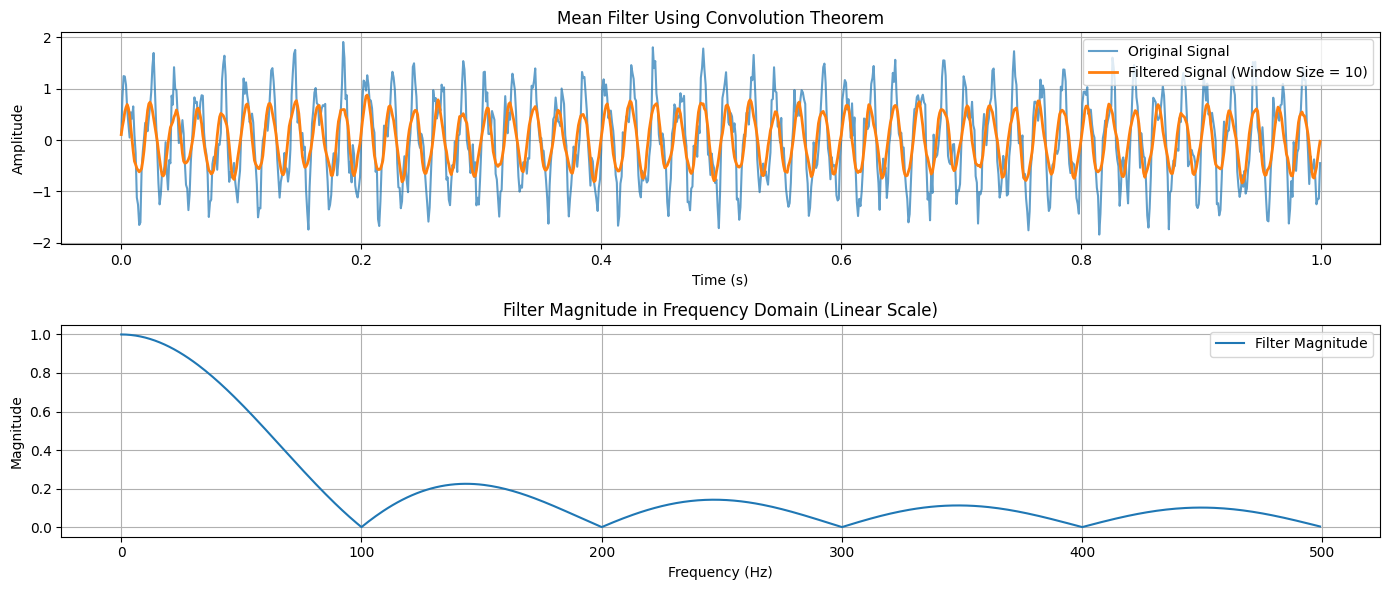

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def mean_filter_freq_corrected(signal, window_size, fs):
    """
    Apply a mean filter using convolution theorem in the frequency domain.

    Parameters:
    - signal: np.ndarray
        The input signal to be filtered.
    - window_size: int
        The size of the moving window.
    - fs: int
        The sampling frequency.

    Returns:
    - filtered_signal: np.ndarray
        The filtered signal.
    - filter_magnitude: np.ndarray
        Magnitude of the filter in the frequency domain.
    - frequencies: np.ndarray
        Frequency vector corresponding to the filter magnitude.
    """
    # Ensure the window size is valid
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")

    # Generate the time-domain filter (boxcar filter)
    time_filter = np.ones(window_size) / window_size

    # Zero-pad the filter to match the signal length
    padded_filter = np.zeros_like(signal)
    padded_filter[:window_size] = time_filter

    # Correct the padding to center the filter in time
    padded_filter = np.roll(padded_filter, -window_size // 2)

    # Compute FFT of the signal and the filter
    fft_signal = np.fft.fft(signal)
    fft_filter = np.fft.fft(padded_filter)

    # Filter in the frequency domain
    fft_filtered_signal = fft_signal * fft_filter

    #%% FILTRO DE FASE
    in_filter_phase = -np.angle(fft_filter)
    f_real = np.cos(in_filter_phase)
    f_imag = np.sin(in_filter_phase)
    filter = f_real + 1j * f_imag

    fft_filtered_signal_dephased = fft_filtered_signal*1#filter

    # Inverse FFT to get the filtered signal
    filtered_signal = np.real(np.fft.ifft(fft_filtered_signal))

    # Magnitude of the filter
    filter_magnitude = np.abs(fft_filter)
    frequencies = np.fft.fftfreq(len(signal), d=1/fs)

    return filtered_signal, filter_magnitude, frequencies

# Example usage
fs = 1000  # Sampling frequency (Hz)
t = np.linspace(0, 1, fs, endpoint=False)  # Time vector
signal = np.sin(2 * np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 120 * t) + np.random.normal(0, 0.2, len(t))  # Signal with noise

# Apply the mean filter in the frequency domain
window_size = 10  # Define the size of the moving window
filtered_signal, filter_magnitude, frequencies = mean_filter_freq_corrected(signal, window_size, fs)

# Plot the original and filtered signals
plt.figure(figsize=(14, 6))

# Time-domain signals
plt.subplot(2, 1, 1)
plt.plot(t, signal, label="Original Signal", alpha=0.7)
plt.plot(t, filtered_signal, label=f"Filtered Signal (Window Size = {window_size})", linewidth=2)
plt.title("Mean Filter Using Convolution Theorem")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()

# Frequency-domain filter magnitude (Linear Scale)
plt.subplot(2, 1, 2)
plt.plot(frequencies[:len(frequencies)//2], filter_magnitude[:len(frequencies)//2], label="Filter Magnitude")
plt.title("Filter Magnitude in Frequency Domain (Linear Scale)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
